In [23]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import distance

length = 429.98331198338406


<Figure size 1080x648 with 0 Axes>

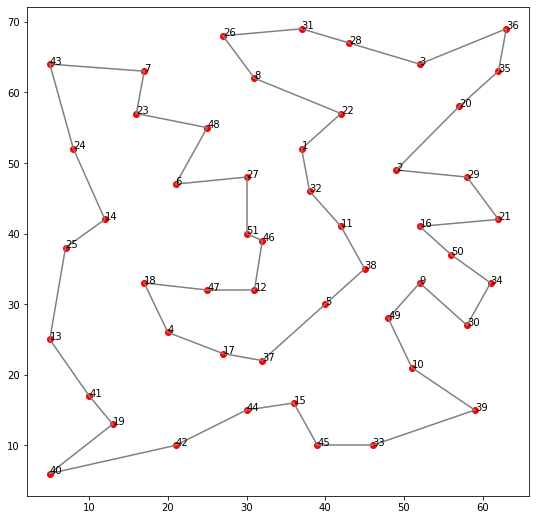

In [41]:

nodes = np.loadtxt('TSP/eil51.tsp.txt', skiprows = 6, max_rows = 51)
opt_tour = np.loadtxt('TSP/eil51.opt.tour.txt', skiprows = 5, max_rows = 51)

d_nodes = {}
for node in nodes: 
    d_nodes[node[0]] = (node[1], node[2])

def plotnodes(nodes): 
    plt.figure(figsize = (9,9))
    for node in nodes:
        plt.plot(node[1], node[2], 'ro')
        plt.annotate(int(node[0]), (node[1], node[2]))

def plotedges(tour): 

    for i, node in enumerate(tour):
        
        if i >= len(tour) - 1: 

            x1 = d_nodes[node][0]
            x2 = d_nodes[tour[0]][0]
            y1 = d_nodes[node][1]
            y2 = d_nodes[tour[0]][1]

        else:  
            x1 = d_nodes[node][0]
            x2 = d_nodes[tour[i+1]][0]
            y1 = d_nodes[node][1]
            y2 = d_nodes[tour[i+1]][1]

        x_coords = [x1,x2]
        y_coords = [y1,y2]

        plt.plot(x_coords, y_coords, color = 'grey')

def tour_length(tour):
    total_length_manual = 0

    for i, node in enumerate(tour):
        
        if i >= len(tour) - 1: 

            x1 = d_nodes[node][0]
            x2 = d_nodes[tour[0]][0]
            y1 = d_nodes[node][1]
            y2 = d_nodes[tour[0]][1]

        else:  
            x1 = d_nodes[node][0]
            x2 = d_nodes[tour[i+1]][0]
            y1 = d_nodes[node][1]
            y2 = d_nodes[tour[i+1]][1]

       
        length_manual = np.sqrt((x1 - x2)**2 + (y1-y2)**2)
        
        total_length_manual += length_manual
    return total_length_manual

plt.figure(figsize = (15,9))
plotnodes(nodes)
plotedges(opt_tour)
print('length = ' + str(tour_length(opt_tour)))




In [42]:

def make_d_nodes(nodes): 
    
    d_nodes = {}
    for node in nodes: 
        d_nodes[node[0]] = (node[1], node[2])

def make_tour_edges(tour): 
    tour_edges = []

    for i, node in enumerate(tour):
        if i < len(opt_tour) - 1: 
            tour_edges.append([node, tour[i+1]])
        else:
            tour_edges.append([node, tour[0]])
    
    return tour_edges

def make_distance_matrix(d_nodes, n_nodes):
        
    distance_matrix = np.zeros((n_nodes,n_nodes))
    for node1 in range(n_nodes):
        for node2 in range(n_nodes): 
            
            x1 = d_nodes[node1+1][0]
            x2 = d_nodes[node2+1][0]
            y1 = d_nodes[node1+1][1]
            y2 = d_nodes[node2+1][1]
            distance_matrix[node1, node2] = np.sqrt((x1 - x2)**2 + (y1-y2)**2)
    
    return distance_matrix
    

def comp_length_from_matrix(tour, distance_matrix):

    tour_edges = make_tour_edges(tour)
    total_distance = 0
    for edge in tour_edges: 
        total_distance += distance_matrix[int((edge[0] - 1)), int((edge[1] - 1))]
    return total_distance

def make_random_route(n_nodes):
    l_nodes = np.arange(1,n_nodes+1)
    return np.random.permutation(l_nodes)
    



In [76]:

n_nodes = 51
distance_matrixeil51 = make_distance_matrix(d_nodes, 51)

random_route = make_random_route(51)

plt.figure(figsize = (15,9))
plotnodes(nodes)
plotedges(random_route)
plt.show()

print(f'Length of tour = {comp_length_from_matrix(random_route, distance_matrixeil51)}')

tour = [2, 3, 6, 1, 5, 4]
def lin2opt(tour): 
    n_nodes = len(tour)
    rand_node1 = np.random.random_integers(1, n_nodes)
    rand_node2 = np.random.random_integers(1, n_nodes)


    i_rand_node1 = np.argwhere(tour == rand_node1)[0][0]
    i_rand_node2 = np.argwhere(tour == rand_node2)[0][0]

    subtour = tour[min(i_rand_node1, i_rand_node2) + 1 : max(i_rand_node1, i_rand_node2)]

    subtour.reverse()

    tour[min(i_rand_node1, i_rand_node2) + 1 : max(i_rand_node1, i_rand_node2)] = subtour
    
    return tour






[2, 3, 6, 1, 5, 4]
2
4
[5, 1, 6, 3]
[2, 5, 1, 6, 3, 4]


C:\Users\danie\AppData\Local\Temp/ipykernel_11792/995879320.py:16: DeprecationWarning: This function is deprecated. Please call randint(1, 6 + 1) instead
  rand_node1 = np.random.random_integers(1, n_nodes)
C:\Users\danie\AppData\Local\Temp/ipykernel_11792/995879320.py:17: DeprecationWarning: This function is deprecated. Please call randint(1, 6 + 1) instead
  rand_node2 = np.random.random_integers(1, n_nodes)
